# Mustererkennung/Machine Learning - Assignment 8



In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from statistics import mean
import random
from numpy import linalg as LA
from sklearn import decomposition
%matplotlib inline

**Load data**

In [2]:
# Load the IRIS dataset
iris = load_iris()
X_iris = iris.data
y_iris = iris.target
names = iris.target_names
feature_names = iris.feature_names

#### Splitting the data into training/test and according to their class memberships

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X_iris, y_iris, test_size=0.2, random_state=None, stratify=y_iris)

# data for training perceptron to distinguish between setosa and virginica/versicolour
X_train_setosa = X_train[np.where(y_train==0)]
X_train_versicolor = X_train[np.where(y_train==1)]
X_train_virginica = X_train[np.where(y_train==2)]
X_train_versicolor_virginica = np.concatenate((X_train_versicolor,X_train_virginica))
y_train_versicolor_virginica = np.array([1]*X_train_versicolor.shape[0] + [0]*X_train_virginica.shape[0])

# data to test perceptron's performance to separate setosa from virginica/versicolour
# set setosa to positive class, versicolour/virginica to negative
y_test_setosa_vs_rest = (y_test == 0).astype(int)


# data to test perceptron's performance to separate versicolour from virginica
# make versicolour the positive class
X_test_versicolor_virginica = X_test[np.where(y_test!=0)]
y_test_versicolor_virginica = y_test[np.where(y_test!=0)]
y_test_versicolor_virginica = (y_test_versicolor_virginica == 1).astype(int)


## Exercise 1: Perceptron
Implement the Perceptron algorithm using Python (incl. Numpy etc.) and use it on the Iris-dataset. Train the algorithm to seperate Setosa from Versicolour and Virginica

In [4]:
class Perceptron:
    def __init__(self, threshold):
        self.threshold = threshold
        self.w_hat = None
        
    def center_data(self, P_X, N_X):
        """This function substracts the mean from the training data and returns the seperate positive/negative sets."""
        m = np.mean(np.concatenate((P_X, N_X)), axis=0)
        return P_X-m, N_X-m
    
    def train(self, P_X, N_X):
        """
        The train function uses the pocket perceptron training algorithm, where the input P_X, N_X
        are the separated positive and negative datasets respectively.
        The algorithm is trained on the mean-centered dataset.
        """
        # center data
        P_centered, N_centered = self.center_data(P_X, N_X)
        # initialize w_hat
        self.w_hat = np.average(P_centered, axis=0)
        print('Initialize weights:', self.w_hat)
        w = self.w_hat
        while np.linalg.norm(self.w_hat - w) <= self.threshold:
            w = self.w_hat
            # select random vector v in NUP
            # randomly choose if taking from N or from P
            tmp = np.random.choice([0,1])
            # if v in P
            if tmp == 1:
                v = np.random.choice(range(P_centered.shape[0]))
                v = P_centered[v,:]
                # if projection of v onto w is positive, continue,
                # else update w_hat with v
                if w @ v <= 0:
                    self.w_hat = w + v
            # if v in N
            else:
                v = np.random.choice(range(N_centered.shape[0]))
                v = N_centered[v,:]                
                # if projection of v onto w is negative, continue,
                # else update w_hat with v
                if w @ v >= 0:
                    self.w_hat = w - v
        print('Final weights:', self.w_hat)
    
    def predict(self, X):
        """This function returns the predicted labels using the heaviside step function."""
        m = np.mean(X, axis=0)
        X_centered = X-m
        Y_pred = (X_centered@self.w_hat > 0).astype(int)
        return Y_pred
    
    
    def accuracy(self, labels, predictions):
        """This function calculates the binary class accuracy for given true/predicted labels"""
        return np.mean(labels == predictions)

**Train single perceptron to distinguish between setosa vs versicolour and virginica:**

Train Perceptron on setosa (P) and versicolor+virginica (N)

In [37]:
Single_Perceptron = Perceptron(0.001)

In [38]:
Single_Perceptron.train(X_train_setosa, X_train_versicolor_virginica)

Initialize weights: [-0.82583333  0.36916667 -2.31       -0.94583333]
Final weights: [-0.68    0.825  -2.05   -0.7625]


**Evaluate performance**

In [41]:
y_pred = Single_Perceptron.predict(X_test)

In [42]:
print('Accuracy of Setosa vs Virginica/Versicolor:',Single_Perceptron.accuracy(y_test_setosa_vs_rest, y_pred))

Accuracy of Setosa vs Virginica/Versicolor: 0.9333333333333333


**Visualize training data and learned weight vector**

Plot centered training data together with learned weight vector.

In [43]:
pca = decomposition.PCA(n_components=2)
# center training data to have perceptron weight vector with respect to zero mean
X_centered = X_train - X_train.mean(axis=0)
pca.fit(np.concatenate((X_centered,[Single_Perceptron.w_hat])))
X = pca.fit_transform(np.concatenate((X_centered,[Single_Perceptron.w_hat])))

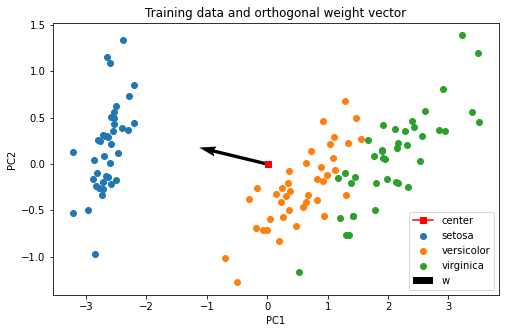

In [44]:
fig, ax = plt.subplots(1, figsize=(8,5))
data = X[:-1,:]- X[:-1,:].mean(axis=0)
for i in range(len(names)):
    ax.scatter(data[np.where(y_train==i),0], data[np.where(y_train==i),1], label=names[i])
ax.plot(X[:-1,:].mean(axis=0)[0],X[:-1,:].mean(axis=0)[1],c='red', marker='s', label='center')
tail = X[:-1,:].mean(axis=0)
ax.quiver(*tail,X[-1,0], X[-1,1], scale=15, label='w') 
ax.legend()
ax.set_title('Training data and orthogonal weight vector')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
plt.show()

## (a) What happens if you use the algorithm to seperate Versicolour from Virginica? (Evaluate multiple runs)

**Training one perceptron on versicolor (P) and virginica (N)**

In [77]:
test = Perceptron(0.001)

In [78]:
test.train(X_train_versicolor, X_train_virginica)

Initialize weights: [-0.27125 -0.105   -0.5825  -0.36125]
Final weights: [ 0.4025  0.1125 -0.57   -0.5525]


In [79]:
y_test = test.predict(X_test_versicolor_virginica)

In [80]:
print("Versicolor vs Virginica accuracy for one trained perceptron:", test.accuracy(y_test, y_test_versicolor_virginica))

Versicolor vs Virginica accuracy for one trained perceptron: 1.0


**Visualize versicolor and virginica training data and learned weight vector**

Plot centered training data and learned weight vector.

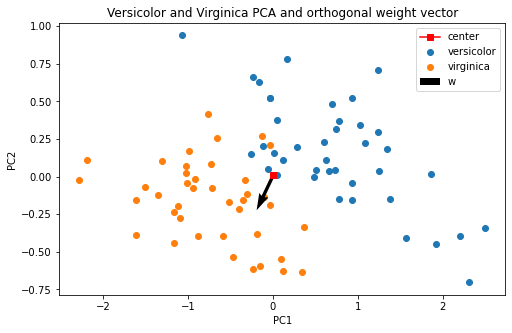

In [85]:
pca_a = decomposition.PCA(n_components=2)
X_centered_a = X_train_versicolor_virginica - X_train_versicolor_virginica.mean(axis=0)
X_a = pca_a.fit_transform(np.concatenate((X_centered_a,[test.w_hat])))
fig, ax = plt.subplots(1, figsize=(8,5))
data_a = X_a[:-1,:]- X_a[:-1,:].mean(axis=0)
for i in range(2):
    ax.scatter(data_a[np.where(y_train_versicolor_virginica==i),0], data_a[np.where(y_train_versicolor_virginica==i),1], label=names[i+1])
ax.plot(X_a[:-1,:].mean(axis=0)[0],X_a[:-1,:].mean(axis=0)[1],c='red', marker='s', label='center')
tail_a = X_a[:-1,:].mean(axis=0)
ax.quiver(*tail_a,X_a[-1,0], X_a[-1,1], scale=10, label='w') 
ax.legend()
ax.set_title('Versicolor and Virginica PCA and orthogonal weight vector')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
plt.show()

**Train multiple perceptrons and report mean accuracy**

In [87]:
%%capture
acc_list = []
for i in range(1):
    clf_versicolor_virginica = Perceptron(threshold = 0.001)
    clf_versicolor_virginica.train(X_train_versicolor, X_train_virginica) # versicolor is the positive class

    y_pred_versicolor_virginica = clf_versicolor_virginica.predict(X_test_versicolor_virginica)

acc_list.append(clf_versicolor_virginica.accuracy(y_test_versicolor_virginica, y_pred_versicolor_virginica))

In [88]:
print("Versicolor vs Virginica mean accuracy:", np.mean(acc_list))

Versicolor vs Virginica mean accuracy: 1.0


## (b) Find a way to solve the problem and obtain the accuracy.

**Result from (a):**

No idea what is problematic with this prediction. The perceptorn trained on versicolor and virginica shows very high accuracy in separating the two species. The 2d visualization of versicolor and virginica might show the two species not being linearly separable, but the classification accuracy shown before proves otherwise. Apparently, in 4D the two classes are well separable.

## Excercise 2: Multilayer-Perceptron (MLP)
Implement a class that builds an MLP with both variable depth D (number of layers) and variable number of neurons ni for each layer i = 1,...,D.

In [17]:
class MLP:
    def __init__(self, threshold, depth, layer_width):
        """
        This constructor sets random network weights and checks if the input depth matches the provided layers.
        """
        self.threshold = threshold
        self.depth = depth
        if not len(layer_width) == (depth + 1):
            raise Exception("'layer_width' needs to be of length 'depth' + 1")  
        self.layer_width = layer_width
        self.network_weights = []
        self.network_biases = []
        width_prev = self.layer_width[0]
        for width in self.layer_width[1:]:
            self.network_weights.append(np.random.randn(width_prev, width)* np.sqrt(1. / width_prev))
            self.network_biases.append(np.zeros((1, width)))
            width_prev = width
    
    def heaviside(self, X):
        """This Function is a tiny implementation of the heaviside step function."""
        return (X > 0).astype(int)
    
    def iterate_trough_network(self, X):
        """This Function passes the input X through all weights and returns the prediction vector."""
        X_i = X.copy()
        for i in range(self.depth):
            z_i = X_i @ self.network_weights[i] + self.network_biases[i]
            X_i = self.heaviside(z_i)
        return X_i
    
    def train(self, X):
        """The train function will be implemented in Assignment 9."""
        raise Exception("The train function will be implemented in Assignment 9!!!")
    
    def predict(self, X):
        """This function passes the input X to the iteration function."""
        return (self.iterate_trough_network(X)).ravel()
    
    def accuracy(self, labels, predictions):
        """This function calculates the binary class accuracy for given true/predicted labels."""
        return np.mean(labels == predictions)

### Produce outputs on the ZIP- Dataset.

#### Load the Zip Dataset

In [19]:
path_to_train = '/Users/Eva/Downloads/zip.train'
path_to_test = '/Users/Eva/Downloads/zip.test'
training_data = np.array(pd.read_csv(path_to_train, sep=' ', header=None))
test_data = np.array(pd.read_csv(path_to_test, sep =' ',header=None))

X_train_zip, y_train_zip = training_data[:,1:-1], training_data[:,0]
X_test_zip, y_test_zip = test_data[:,1:], test_data[:,0]

# We only want to classify two different digits. You can choose which digits you want to classify youself

X_train_zip = X_train_zip[np.logical_or(y_train_zip == 0, y_train_zip == 1)]
y_train_zip = y_train_zip[np.logical_or(y_train_zip == 0, y_train_zip == 1)]

X_test_zip = X_test_zip[np.logical_or(y_test_zip == 0, y_test_zip == 1)]
y_test_zip = y_test_zip[np.logical_or(y_test_zip == 0, y_test_zip == 1)]

In [20]:
X_train_zip.shape

(2199, 256)

#### Classify the Zip-Dataset with the random initial weights

In [21]:
mlp_network = MLP(threshold=0.01, depth=2, layer_width=[X_train_zip.shape[1], 10, 1])

In [22]:
print(mlp_network.network_weights[0].shape)
print(mlp_network.network_weights[1].shape)
print(mlp_network.network_biases[0].shape)
print(mlp_network.network_biases[1].shape)

(256, 10)
(10, 1)
(1, 10)
(1, 1)


In [23]:
y_pred_mlp = mlp_network.predict(X_train_zip)

In [24]:
mlp_network.accuracy(y_train_zip, y_pred_mlp)

0.43019554342883126

In [25]:
np.unique(y_pred_mlp, return_counts=True)

(array([0, 1]), array([1937,  262]))

In [26]:
np.unique(y_train_zip, return_counts=True)

(array([0., 1.]), array([1194, 1005]))

#### Get a mean accuracy over multiple runs

In [27]:
acc_list_mlp = []
n_runs = 100
for i in range(n_runs):
    mlp_network = MLP(threshold=0.01, depth=2, layer_width=[X_train_zip.shape[1], 10, 1])
    y_pred_loop = mlp_network.predict(X_train_zip)
    acc_list_mlp.append(mlp_network.accuracy(y_train_zip, y_pred_loop))
print("Mean Acc over", n_runs, "runs, with random weights is:", np.mean(acc_list_mlp))

Mean Acc over 100 runs, with random weights is: 0.5153387903592542


### Result:
Without any training, the predictions of the MLP are pretty much random at an accuracy of 50%